**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

Here's some of the code you've written so far. Start by running it again.

In [2]:
# Import helpful libraries
import pandas as pd
import torch
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# Load the data
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# i use all the features that don't throw error
features=['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
          '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
          'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch',
          '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'
         ]

# fill n/a values with median
for f in features:
    train_data[f] = train_data[f].fillna(train_data[f].median())
    test_data[f] = test_data[f].fillna(test_data[f].median())
    

# looking at the training data
train_data[features].head()


# every feature is an int64 -> one hot encode not needed
#for f in features:
#    print(X[f].dtype)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,856,854,0,1710,...,0,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,1262,0,0,1262,...,1,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,920,866,0,1786,...,1,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,961,756,0,1717,...,1,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,1145,1053,0,2198,...,1,192,84,0,0,0,0,0,12,2008


In [4]:
# normalize
# what to do with SALEPRICE - scale too? - yes, apply log transform, then inverse log = exp at the end
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(train_data[features])
train_data_scaled = pd.DataFrame(min_max_scaler.transform(train_data[features]))
test_data_scaled = pd.DataFrame(min_max_scaler.transform(test_data[features]))

# !! egyben nem lehet transzformálni a train_data-val, mert azzal meg a test_data-t nem lehetne
train_labels_scaled = min_max_scaler.fit_transform(train_data['SalePrice'].values.reshape(-1, 1))


# looking at scaled data
#train_data_scaled.head()
#print(train_labels_scaled[-110:-100])

# splitting train_data_scaled into normalized training and validation dataset
train_X, val_X, train_labels, val_labels = train_test_split(train_data_scaled, train_labels_scaled, test_size=0.2, random_state=0)

# turn everything to a tensor
train_X =      torch.tensor(train_X.values).to(torch.float32)
train_labels = torch.tensor(train_labels).to(torch.float32)
val_X =        torch.tensor(val_X.values).to(torch.float32)
val_labels =   torch.tensor(val_labels).to(torch.float32)

test_X =       torch.tensor(test_data_scaled.values).to(torch.float32)

print(train_X.shape)

torch.Size([1168, 25])


In [5]:
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
# defining the dataset for dataloaders
class MyDataset(Dataset):
    def __init__(self, tensor, labels):
        self.X = tensor
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# making the minbatches
train_ds = MyDataset(train_X, train_labels)
val_ds = MyDataset(val_X, val_labels)
batch_s = 40
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_s, shuffle=True)
validationloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_s, shuffle=True)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
# Define an MLP
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 128
        hidden_2 = 8
        self.fc1 = nn.Linear(train_X.shape[1], hidden_1)
        self.fc2 = nn.Linear(hidden_1, 1)
        #self.fc3 = nn.Linear(hidden_2, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# initialize the NN
model = Net()
print(model)

# rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
# print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Net(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [7]:
from torchmetrics.regression import MeanAbsoluteError
# define MAE loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.05)

# to calc MAE
acc = MeanAbsoluteError()

In [8]:
import numpy as np
# learning
epochs = 1000
tot_train_loss = []
tot_val_loss = []
tot_train_MAE = []
tot_val_MAE = []
valid_loss_min = np.Inf

for e in range(epochs):
    for house, price in trainloader:
        optimizer.zero_grad()
        output = model(house).squeeze(-1)
        loss = criterion(output, price)
        loss.backward()
        optimizer.step()
        tot_train_loss.append(loss.item())
        tot_train_MAE.append(acc(output.view(-1), price.view(-1)).item())
    else:
        with torch.no_grad():
            for v_house, v_price in validationloader:
                val_out = model(v_house).squeeze(-1)
                val_loss = criterion(val_out, v_price)
                tot_val_loss.append(val_loss.item())
                tot_val_MAE.append(acc(val_out.view(-1), v_price.view(-1)).item())
                
            # calculate average losses
            train_loss = sum(tot_train_MAE) / len(tot_train_MAE)
            valid_loss = sum(tot_val_MAE) / len(tot_val_MAE)


            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'model_housing_prices.pt')
                valid_loss_min = valid_loss
                
    if (e+1)%50==0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training MAE: {:.4f}.. ".format(train_loss),
          "Test MAE: {:.4f}.. ".format(valid_loss))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, targ

Validation loss decreased (inf --> 0.074323).  Saving model ...
Epoch: 50/1000..  Training MAE: 0.0808..  Test MAE: 0.0782.. 
Epoch: 100/1000..  Training MAE: 0.0797..  Test MAE: 0.0789.. 
Epoch: 150/1000..  Training MAE: 0.0793..  Test MAE: 0.0786.. 
Epoch: 200/1000..  Training MAE: 0.0792..  Test MAE: 0.0786.. 
Epoch: 250/1000..  Training MAE: 0.0791..  Test MAE: 0.0786.. 
Epoch: 300/1000..  Training MAE: 0.0790..  Test MAE: 0.0784.. 
Epoch: 350/1000..  Training MAE: 0.0790..  Test MAE: 0.0784.. 
Epoch: 400/1000..  Training MAE: 0.0789..  Test MAE: 0.0784.. 
Epoch: 450/1000..  Training MAE: 0.0789..  Test MAE: 0.0784.. 
Epoch: 500/1000..  Training MAE: 0.0788..  Test MAE: 0.0784.. 
Epoch: 550/1000..  Training MAE: 0.0788..  Test MAE: 0.0784.. 
Epoch: 600/1000..  Training MAE: 0.0788..  Test MAE: 0.0784.. 
Epoch: 650/1000..  Training MAE: 0.0788..  Test MAE: 0.0784.. 
Epoch: 700/1000..  Training MAE: 0.0788..  Test MAE: 0.0784.. 
Epoch: 750/1000..  Training MAE: 0.0788..  Test MAE: 0.

Now, read the file of "test" data, and apply your model to make predictions.

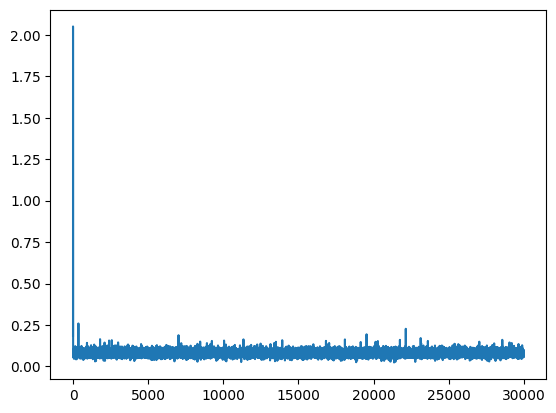

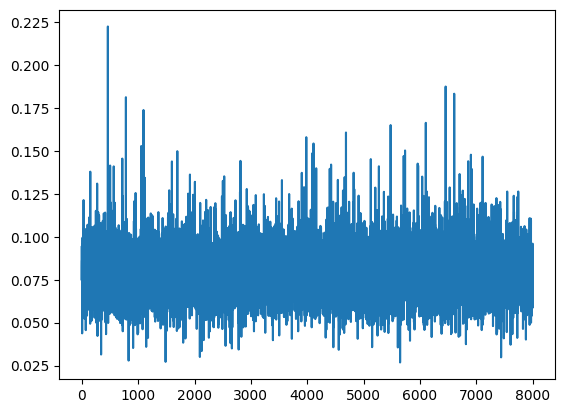

In [9]:
import matplotlib.pyplot as plt
plt.plot(tot_train_MAE)
plt.show()
plt.plot(tot_val_MAE)
plt.show()

Before submitting, run a check to make sure your `test_preds` have the right format.

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [10]:
scaled_preds = model(test_X)
predictions = min_max_scaler.inverse_transform(scaled_preds.detach().numpy())
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': predictions.squeeze(-1)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://storage.googleapis.com/kaggle-media/learn/images/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Data** tab near the top of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*